# I. Set up:

In [4]:
!pip install opencv-python


  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/fb/c4/f574ba6f04e6d7bf8c38d23e7a52389566dd7631fee0bcdd79ea07ef2dbf/opencv_python-4.8.0.76-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.1 MB 2.0 MB/s eta 0:00:20
   ---------------------------------------- 0.2/38.1 MB 3.8 MB/s eta 0:00:10
    --------------------------------------- 0.6/38.1 MB 5.0 MB/s eta 0:00:08
   - -------------------------------------- 1.2/38.1 MB 6.8 MB/s eta 0:00:06
   - -------------------------------------- 1.7/38.1 MB 7.6 MB/s eta 0:00:05
   --- ------------------------------------ 2.9/38.1 MB 11.0 MB/s eta 0:00:04
   --- ------------------------------------ 3.6/38.1 MB 11.4 MB/s eta 0:00:04
   ---- ----------------------------------- 4.3/38.1 MB 12.0 MB/s eta 0:00:03
   ----- ---------------------------------- 5.1/38.1 MB 12.4 MB/s eta 0:00:03
   ----- ---

In [5]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [11]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [12]:
!tar -xf lfw.tgz

In [14]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [15]:
import uuid

In [16]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\67bea44b-5c20-11ee-98bb-38f3ab759666.jpg'

In [31]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

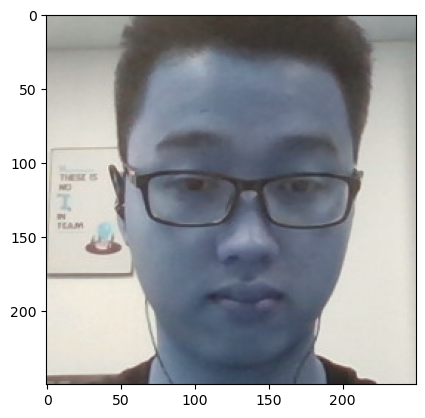

In [25]:
plt.imshow(frame)

In [26]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [27]:
import os
import uuid

In [28]:
img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [29]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [32]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [33]:
dir_test = anchor.as_numpy_iterator()

In [34]:
print(dir_test.next())

b'data\\anchor\\747.jpg'


In [35]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [36]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [37]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [38]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [39]:
samples = data.as_numpy_iterator()

In [40]:
example = samples.next()

In [41]:
example

(b'data\\anchor\\98.jpg', b'data\\positive\\329.jpg', 1.0)

In [42]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [43]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [44]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [45]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [46]:
inp = Input(shape=(100,100,3), name='input_image')

In [47]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [48]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [49]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [50]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [51]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [52]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [59]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [60]:
embedding = make_embedding()

In [61]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [54]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [55]:
l1 = L1Dist()

In [56]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [62]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [63]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [64]:
siamese_layer = L1Dist()

In [65]:
distances = siamese_layer(inp_embedding, val_embedding)

In [66]:
classifier = Dense(1, activation='sigmoid')(distances)

In [67]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [68]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [69]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [70]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [71]:
siamese_model = make_siamese_model()

In [72]:
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [73]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [74]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [75]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [76]:
test_batch = train_data.as_numpy_iterator()


In [77]:
batch_1 = test_batch.next()

In [78]:
X = batch_1[:2]

In [79]:
y = batch_1[2]

In [80]:
y

array([0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

In [81]:
tf.losses.BinaryCrossentropy??

In [82]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [83]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [84]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [85]:
EPOCHS = 50

In [86]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
101/101 [==============================] - 1498s 15s/step
0.0012862235 0.89203084 0.9956958

 Epoch 2/50
1/1 [==============================] - 1s 890ms/step


101/101 [==============================] - 1489s 15s/step
0.00027168897 1.0 1.0

 Epoch 3/50
1/1 [==============================] - 1s 807ms/step


101/101 [==============================] - 1441s 14s/step
0.0003154299 0.9935567 1.0

 Epoch 4/50
101/101 [==============================] - 1448s 14s/step
1.4413589e-06 1.0 1.0

 Epoch 5/50
1/1 [==============================] - 1s 813ms/step


101/101 [==============================] - 1449s 14s/step
0.0016513235 0.9986807 0.99736494

 Epoch 6/50
1/1 [==============================] - 1s 766ms/step


101/101 [==============================] - 1906s 19s/step
1.1595876e-06 0.9987358 0.9875

 Epoch 7/50
 12/101 [==>...........................] - ETA: 21:30

KeyboardInterrupt: 

In [87]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [88]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [89]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 784ms/step


In [90]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]

In [91]:
y_true

array([1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.],
      dtype=float32)

In [92]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [93]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [94]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 244ms/step
1.0 1.0


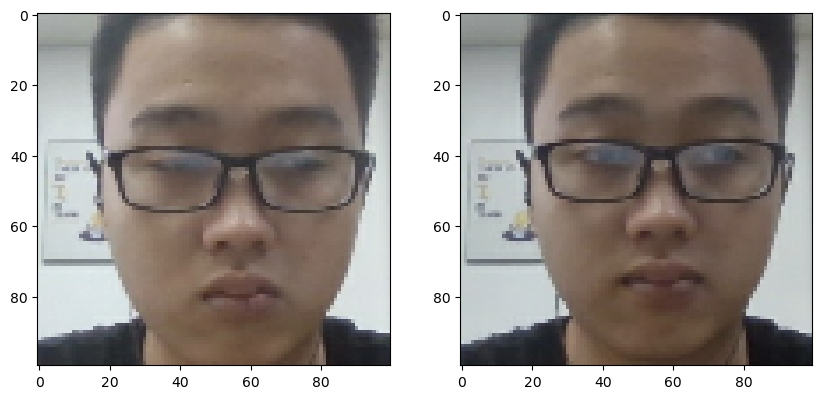

In [95]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [96]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [97]:
L1Dist

__main__.L1Dist

In [98]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

OSError: No file or directory found at siamesemodelv2.h5

In [99]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 222ms/step


array([[7.7782285e-01],
       [1.1359401e-07]], dtype=float32)

In [100]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [101]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [102]:
os.listdir(os.path.join('application_data', 'verification_images'))

['1.jpg',
 '10.jpg',
 '11.jpg',
 '12.jpg',
 '13.jpg',
 '14.jpg',
 '15.jpg',
 '16.jpg',
 '17.jpg',
 '18.jpg',
 '19.jpg',
 '2.jpg',
 '20.jpg',
 '21.jpg',
 '22.jpg',
 '23.jpg',
 '24.jpg',
 '25.jpg',
 '26.jpg',
 '27.jpg',
 '28.jpg',
 '29.jpg',
 '3.jpg',
 '30.jpg',
 '31.jpg',
 '32.jpg',
 '33.jpg',
 '34.jpg',
 '35.jpg',
 '36.jpg',
 '37.jpg',
 '38.jpg',
 '39.jpg',
 '4.jpg',
 '40.jpg',
 '41.jpg',
 '42.jpg',
 '43.jpg',
 '44.jpg',
 '45.jpg',
 '46.jpg',
 '47.jpg',
 '48.jpg',
 '49.jpg',
 '5.jpg',
 '50.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg']

In [103]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [104]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\1.jpg
application_data\verification_images\10.jpg
application_data\verification_images\11.jpg
application_data\verification_images\12.jpg
application_data\verification_images\13.jpg
application_data\verification_images\14.jpg
application_data\verification_images\15.jpg
application_data\verification_images\16.jpg
application_data\verification_images\17.jpg
application_data\verification_images\18.jpg
application_data\verification_images\19.jpg
application_data\verification_images\2.jpg
application_data\verification_images\20.jpg
application_data\verification_images\21.jpg
application_data\verification_images\22.jpg
application_data\verification_images\23.jpg
application_data\verification_images\24.jpg
application_data\verification_images\25.jpg
application_data\verification_images\26.jpg
application_data\verification_images\27.jpg
application_data\verification_images\28.jpg
application_data\verification_images\29.jpg
application_data\verification_imag

In [105]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [106]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [107]:
np.sum(np.squeeze(results) > 0.9)

NameError: name 'results' is not defined

In [108]:
results

NameError: name 'results' is not defined